In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('data.tsv', header=None, sep='\t')

In [2]:
""" Simple preprocessing of the dataset """

# Drop URLs and last column which contains NaN for some reason
df = df.drop(columns=[0])
df = df.drop(columns=[8])
# Rename columns so they are more readable
df = df.rename(columns={1: "name", 2: "price", 3: "size", 4: "battery", 5: "procfreq", 6: "resolution", 7: "display"})

# Prices are with commas and spaces (between thousands and hundreds), replace them with dots and remove spaces
df['price'] = df['price'].str.replace(',', '.')
df['price'] = df['price'].str.replace(' ', '').astype(float)

# Create a new column for brand
df["brand"] = df["name"].str.split(' ').str[0].str.split('/').str[0]

df.head()

""" Join similar display types """

df['display'] = df['display'].str.lower()

displays = df['display'].unique().astype(str)

# Join AMOLED groups together
amoled = [d for d in displays if 'amoled' in d]
df = df.replace(amoled, 'AMOLED')

# Join LCD groups together
lcd = [x for x in displays if 'lcd' in x]
df = df.replace(lcd, 'LCD')

# Join OLED groups together
oled = [x for x in displays if 'oled' in x and 'amoled' not in x]
df = df.replace(oled, 'OLED')

# Join the rest of the displays together
rest = [x for x in displays if x not in amoled and x not in lcd and x not in oled]
df = df.replace(rest, 'Others')

# First dataset preparation

In [3]:
""" Keep only relevant columns """
df1 = df[["price", "procfreq", "display", "brand"]]
df1.head()

,price,procfreq,display,brand
0,876.2,3.30,OLED,Honor
1,321.0,2.75,AMOLED,Samsung
2,198.9,2.40,AMOLED,Samsung
3,239.9,2.40,AMOLED,Samsung
4,163.3,2.20,AMOLED,Samsung


### Missing values

In [4]:
""" Check for missing values """
df1_nan = df1[df1.isnull().any(axis=1)]
df1_nan

,price,procfreq,display,brand
29,150.4,NaN,NaN,Xiaomi
43,170.8,NaN,LCD,Oppo
122,599.0,NaN,NaN,ThinkPhone


In [5]:
""" Drop picked rows """
df1 = df1.drop(index=122)
print(df1[df1.isnull().any(axis=1)])

    price  procfreq display   brand
29  150.4       NaN     NaN  Xiaomi
43  170.8       NaN     LCD    Oppo


In [6]:
""" Fill the remaining NaN values with the mean of the column from the same brand """

# Print Oppo brand before filling NaN values
print(df1[df1["brand"] == "Oppo"].to_string())
print()

# Fill Oppo NaN values with mean and print again  
procfreq_means = df1.groupby('brand')["procfreq"].mean()
df1.loc[43, "procfreq"] = procfreq_means["Oppo"]
print(df1[df1["brand"] == "Oppo"].to_string())
print()

# Do the same for the other missing values
print(df1.iloc[29].to_string())
print()

display_counts = df1.groupby('brand')["display"].value_counts()
df1.loc[29, "procfreq"] = procfreq_means["Xiaomi"]
# Here we see that the highest count for Xiaomi is AMOLED, so we fill the NaN value with AMOLED
print(display_counts["Xiaomi"], "\n")
df1.loc[29, "display"] = "AMOLED"
print(df1.iloc[29].to_string())

df1_nan = df1[df1.isnull().any(axis=1)]
print(f"\nRemaining NaN values: {len(df1_nan)}")


     price  procfreq display brand
37   230.4       2.4    OLED  Oppo
42   378.8       2.5  AMOLED  Oppo
43   170.8       NaN     LCD  Oppo
118  228.9       2.2     LCD  Oppo
142  159.1       2.3     LCD  Oppo

     price  procfreq display brand
37   230.4      2.40    OLED  Oppo
42   378.8      2.50  AMOLED  Oppo
43   170.8      2.35     LCD  Oppo
118  228.9      2.20     LCD  Oppo
142  159.1      2.30     LCD  Oppo

price        150.4
procfreq       NaN
display        NaN
brand       Xiaomi

display
AMOLED    21
LCD       16
OLED       1
Name: count, dtype: int64 

price          150.4
procfreq    2.435526
display       AMOLED
brand         Xiaomi

Remaining NaN values: 0


### Deleting outliers

<Axes: xlabel='price', ylabel='procfreq'>

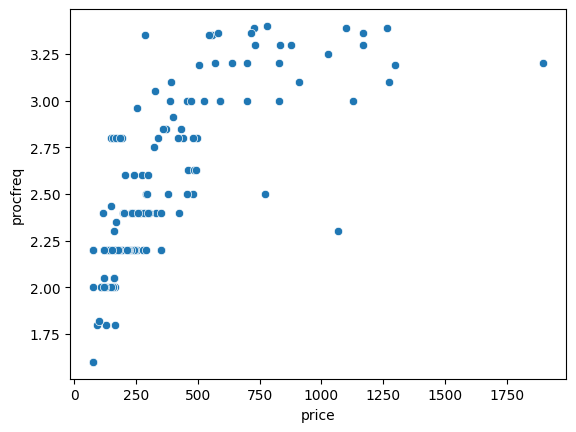

In [7]:
sns.scatterplot(data=df1, x="price", y="procfreq")

In [8]:
""" Calculate outliers based on |z-index| > 3 """

# Calculate z-scores for each row
z_scores1 = abs(stats.zscore(df1[["price", "procfreq"]]))
# Outliers are rows where at least one z-score is greater than 3
outliers1 = z_scores1[z_scores1 > 3].any(axis=1)
# Pick outliers
df1_outliers = df1[outliers1]
print(df1_outliers)

df1.drop(index=[28, 52, 90], inplace=True)

     price  procfreq display    brand
78  1298.8      3.19    OLED    Honor
90  1898.8      3.20  AMOLED  OnePlus


<Axes: xlabel='price', ylabel='procfreq'>

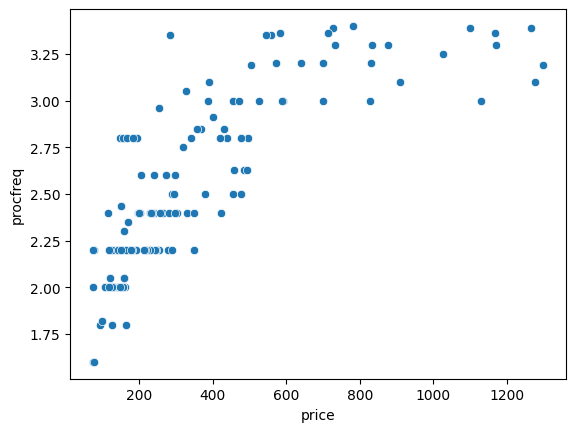

In [9]:
sns.scatterplot(data=df1, x="price", y="procfreq")

### Discretization of numerical variables

In [10]:
pd.cut(df1["procfreq"], bins=5, retbins=True, labels=["very low", "low", "medium", "high", "very high"])

(0      very high
 1           high
 2         medium
 3         medium
 4            low
          ...    
 145         high
 146          low
 147          low
 148          low
 149          low
 Name: procfreq, Length: 146, dtype: category
 Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high'],
 array([1.5982, 1.96  , 2.32  , 2.68  , 3.04  , 3.4   ]))

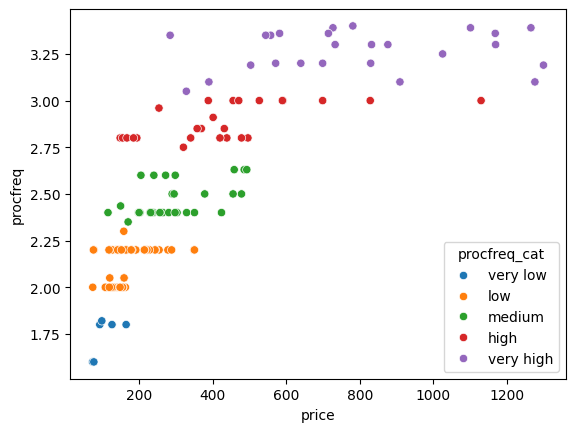

In [11]:
""" Categorize procfreq into 5 categories """

df1["procfreq_cat"] = pd.cut(df1["procfreq"], bins=5, labels=["very low", "low", "medium", "high", "very high"])
sns.scatterplot(data=df1, x="price", y="procfreq", hue="procfreq_cat")

# Drop the original procfreq column
df1 = df1.drop(columns=["procfreq"])

In [12]:
df1

,price,display,brand,procfreq_cat
0,876.2,OLED,Honor,very high
1,321.0,AMOLED,Samsung,high
2,198.9,AMOLED,Samsung,medium
3,239.9,AMOLED,Samsung,medium
4,163.3,AMOLED,Samsung,low
...,...,...,...,...
145,358.3,AMOLED,Xiaomi,high
146,121.0,AMOLED,POCO,low
147,152.6,LCD,POCO,low
148,118.9,LCD,Xiaomi,low


In [13]:
""" Store dataset to a new file """
df1.to_csv('dataset1.csv', sep=',', index=False)

# Second dataset preparation

In [14]:
""" Keep only relevant columns """
df2 = df[["size", "battery", "procfreq", "resolution", "display"]]
df2.head()

,size,battery,procfreq,resolution,display
0,6.8,5600.0,3.30,180.0,OLED
1,6.6,5000.0,2.75,50.0,AMOLED
2,6.5,5000.0,2.40,50.0,AMOLED
3,6.6,5000.0,2.40,50.0,AMOLED
4,6.5,5000.0,2.20,50.0,AMOLED


### Missing values

In [15]:
""" Check for missing values """
df2_nan = df2[df2.isnull().any(axis=1)]
df2_nan

,size,battery,procfreq,resolution,display
29,NaN,NaN,NaN,NaN,NaN
43,6.72,5000.0,NaN,50.0,LCD
122,NaN,NaN,NaN,NaN,NaN


In [16]:
""" Drop values with more than 1 NaN """

df2 = df2.dropna(thresh=2)

""" Fill the remaining NaN values with the mean of the column """
df2 = df2.fillna(df["procfreq"].mean())

print(df2[df2.isnull().any(axis=1)])

Empty DataFrame
Columns: [size, battery, procfreq, resolution, display]
Index: []


### Outliers

     size  battery  procfreq  resolution display
6    6.67   5000.0      2.80       200.0  AMOLED
8    6.67   5000.0      2.20       200.0  AMOLED
22   6.67   5000.0      2.60       200.0  AMOLED
52   3.63   4200.0      2.50        50.0    OLED
57   4.00   4000.0      3.00        50.0    OLED
70   6.67   5000.0      2.80       200.0  AMOLED
93   6.80   5000.0      3.39       200.0  AMOLED
96   6.67   5100.0      2.40       200.0  AMOLED
113  3.40   3700.0      3.36        12.0  AMOLED
114  6.70   5000.0      2.50       200.0  AMOLED


<Axes: xlabel='size', ylabel='battery'>

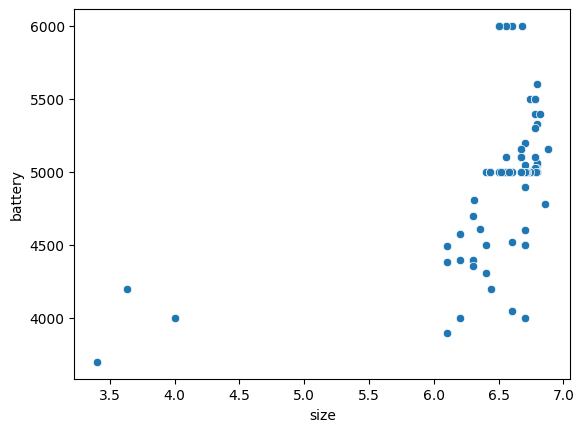

In [17]:
# Calculate z-scores for each row
z_scores2 = abs(stats.zscore(df2[["size", "battery", "procfreq", "resolution"]]))
# Outliers are rows where at least one z-score is greater than 3
outliers2 = z_scores2[z_scores2 > 3].any(axis=1)
# Pick outliers
df2_outliers = df2[outliers2]
print(df2_outliers)

sns.scatterplot(data=df2, x="size", y="battery")

In [18]:
""" Drop size outliers """
df2 = df2.drop(index=[52, 57, 113])

<Axes: xlabel='size', ylabel='battery'>

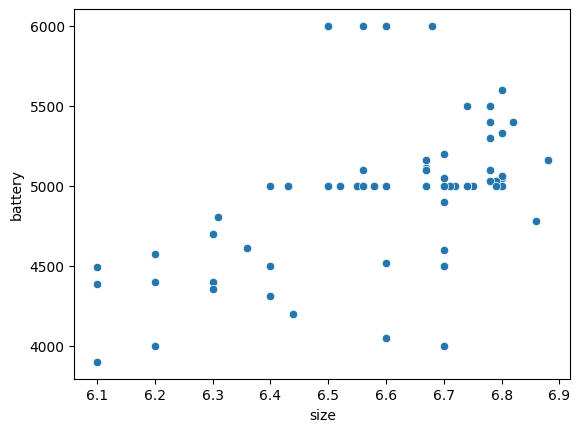

In [19]:
sns.scatterplot(data=df2, x="size", y="battery")

### Transformation of categorical variables into numerical

In [20]:
""" One-hot encode display """
one_hot = pd.get_dummies(df2["display"], dtype=int)
df2 = pd.concat([df2, one_hot], axis=1)
df2 = df2.drop(columns=["display"])

### Normalization of numerical variables to <0,1> or <-1,1> ranges

In [21]:
# stats.zscore(df2[["size", "battery", "procfreq", "resolution"]])

def normalize(values):
    min = values.min()
    max = values.max()
    return (values - min) / (max - min)

df2["size"] = normalize(df2["size"])
df2["battery"] = normalize(df2["battery"])
df2["procfreq"] = normalize(df2["procfreq"])
df2["resolution"] = normalize(df2["resolution"])


In [22]:
df2

,size,battery,procfreq,resolution,AMOLED,LCD,OLED,Others
0,0.897436,0.809524,0.944444,0.895833,0,0,1,0
1,0.641026,0.523810,0.638889,0.218750,1,0,0,0
2,0.512821,0.523810,0.444444,0.218750,1,0,0,0
3,0.641026,0.523810,0.444444,0.218750,1,0,0,0
4,0.512821,0.523810,0.333333,0.218750,1,0,0,0
...,...,...,...,...,...,...,...,...
145,0.730769,0.523810,0.694444,0.520833,1,0,0,0
146,0.423077,0.523810,0.250000,0.291667,1,0,0,0
147,0.615385,0.523810,0.333333,0.218750,0,1,0,0
148,0.615385,0.523810,0.333333,0.218750,0,1,0,0


In [23]:
""" Save the dataset to a new file """
df2.to_csv('dataset2.csv', sep=',', index=False)